<a href="https://colab.research.google.com/github/leoquiroa/LoanRisk/blob/master/FICO_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U -q PyDrive
!pip install -U -q catboost

     |████████████████████████████████| 63.9MB 61kB/s 


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, f1_score

from catboost import Pool, CatBoostClassifier

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# The shareable link
link_x = 'https://drive.google.com/open?id=11cliuBAQTUsPQdwo8bwQUro-y8_OWHA-' 
link_y = 'https://drive.google.com/open?id=1UB-SX1JJU1_AimlP4ymc3vnXdra8rvZq'

In [0]:
def get_df(link):
  fluff, id = link.split('=')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('file.csv')
  df = pd.read_csv('file.csv')
  return df.drop(['ix'], axis=1)

Read data

In [7]:
X = get_df(link_x)
X.head()

acc_open_past_24mths addr_state  ...  total_rev_hi_lim  verification_status
0                   3.0         OK  ...             500.0             Verified
1                  15.0         FL  ...           52400.0      Source Verified
2                   5.0         NH  ...            6200.0         Not Verified
3                   2.0         AL  ...            8800.0      Source Verified
4                   3.0         WA  ...           31000.0      Source Verified

[5 rows x 87 columns]

In [0]:
def fico_letter(row):
    if (row >= 630 and row <= 689): return 'Fair'
    elif row >= 690 and row <= 719: return 'Good'
    elif row >= 720 and row <= 850: return 'Excellent'

In [0]:
X['fico_letter'] = X['fico_range_low'].apply(fico_letter) 
X['fico_letter'].value_counts()
y = X['fico_letter']

Model

In [0]:
def split_data(X,y,type_risk):
  X_mod = X[X.grade == type_risk].copy()
  X_mod = X_mod.drop(['grade', 'int_rate','fico_range_low','fico_letter'], axis=1, errors='ignore')
  y_mod = y[X_mod.index]

  X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, stratify=y_mod, random_state=0)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)
  return [X_train,X_val,X_test,y_train,y_val,y_test]

In [0]:
def pooling(X_train,X_val,X_test,y_train,y_val,y_test):
  cat_feat_ind = (X_train.dtypes == 'object').to_numpy().nonzero()[0]
  pool_train = Pool(X_train, y_train, cat_features=cat_feat_ind)
  pool_val = Pool(X_val, y_val, cat_features=cat_feat_ind)
  pool_test = Pool(X_test, y_test, cat_features=cat_feat_ind)
  return [pool_train,pool_val,pool_test]

In [0]:
def fit_model(y_train,pool_train,pool_val):
  n = y_train.value_counts()
  n_min = n.min()
  model = CatBoostClassifier(iterations=1000,
                             learning_rate=0.03,
                             depth=2,
                             early_stopping_rounds=100,
                             loss_function='MultiClass',
                            verbose=False,
                            random_state=0
                            )
  model.fit(pool_train, eval_set=pool_val, plot=True)
  return model

In [0]:
def build_df_plot(y_test,y_pred_test):
  y_pred_count = pd.DataFrame(y_pred_test)[0].value_counts()
  y_real_count = y_test.value_counts()
  pred_fair = y_pred_count['Fair'] if 'Fair' in y_pred_count else 0
  pred_good = y_pred_count['Good'] if 'Good' in y_pred_count else 0
  pred_exce = y_pred_count['Excellent'] if 'Excellent' in y_pred_count else 0
  df = pd.DataFrame({
      'Factor': ['Fair', 'Good', 'Excellent'],
      'Predict': [pred_fair, pred_good, pred_exce],
      'Real': [y_real_count['Fair'], y_real_count['Good'], y_real_count['Excellent']]
  })
  return df

In [0]:
def plot_bar_comparison(df):
  fig, ax1 = plt.subplots(figsize=(10, 10))
  tidy = df.melt(id_vars='Factor').rename(columns=str.title)
  ax = sns.barplot(x='Factor', y='Value', hue='Variable', data=tidy, ax=ax1)
  sns.despine(fig)
  ax.set(xlabel='FICO type', ylabel='total')

In [0]:
def calculate_risk(type_risk):
  [X_train,X_val,X_test,y_train,y_val,y_test] = split_data(X,y,type_risk)
  [pool_train,pool_val,pool_test] = pooling(X_train,X_val,X_test,y_train,y_val,y_test)
  model = fit_model(y_train,pool_train,pool_val)
  y_pred_test = model.predict(pool_test)
  df = build_df_plot(y_test,y_pred_test)
  plot_bar_comparison(df)
  print('Accuracy: ' + str(accuracy_score(y_test, y_pred_test)))
  return df

Risk E

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7369198312236287


Factor  Predict  Real
0       Fair     3447  2930
1       Good     1105  1421
2  Excellent      188   389

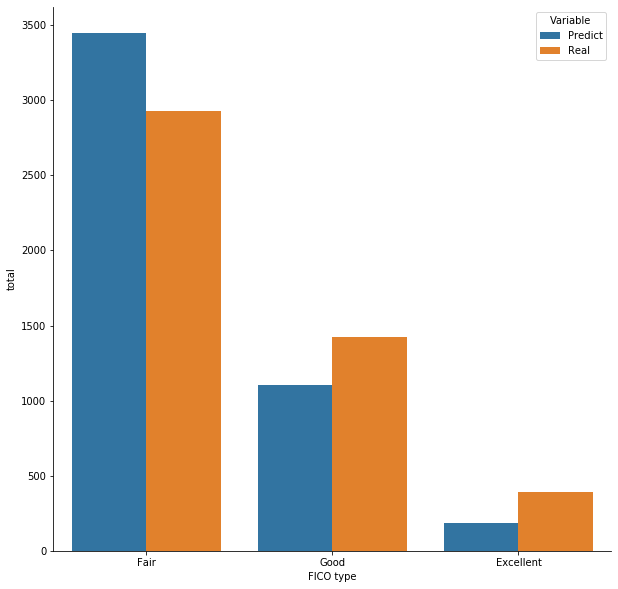

In [44]:
calculate_risk('E')

Risk D

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7331131966168463


Factor  Predict   Real
0       Fair    12011  10285
1       Good     4340   5472
2  Excellent      911   1505

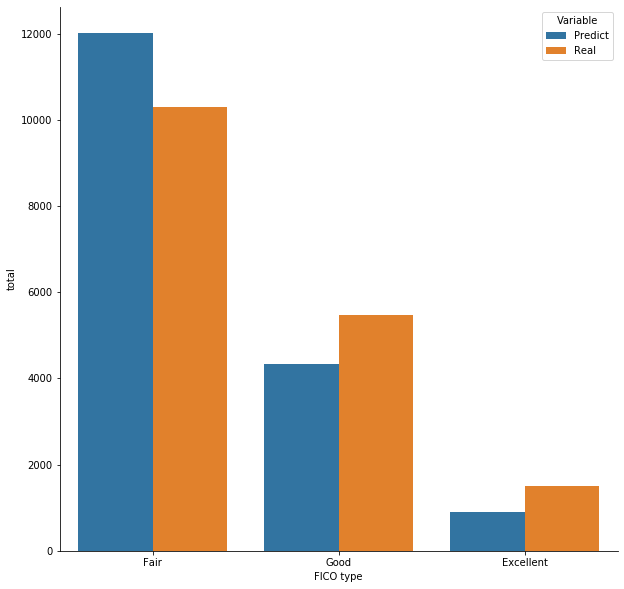

In [45]:
calculate_risk('D')

Risk C

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7174344905874562


Factor  Predict   Real
0       Fair    17175  15598
1       Good    10460  11042
2  Excellent     4078   5073

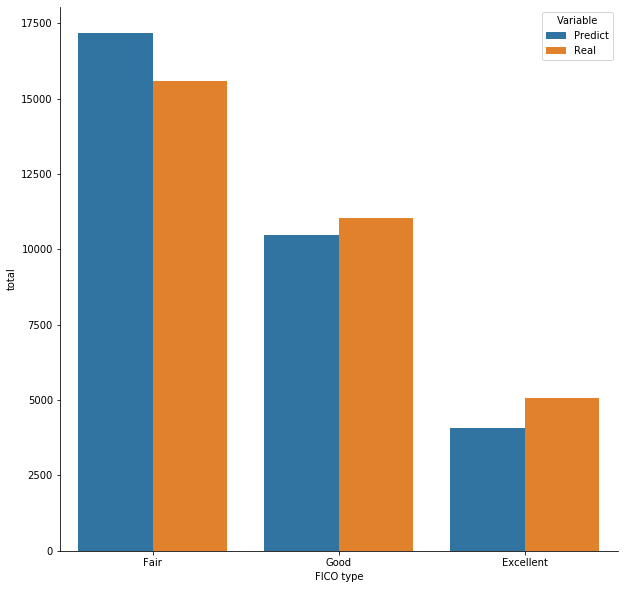

In [46]:
calculate_risk('C')

Risk B

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.7154377228227039


Factor  Predict   Real
0       Fair    11050  11379
1       Good    12138  11926
2  Excellent    12154  12037

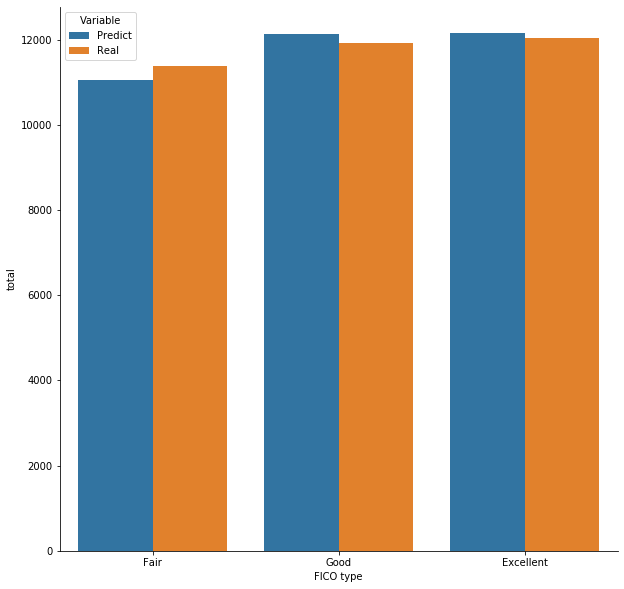

In [47]:
calculate_risk('B')

Risk A

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.778221630418701


Factor  Predict   Real
0       Fair     3288   4591
1       Good     7848   8599
2  Excellent    22659  20605

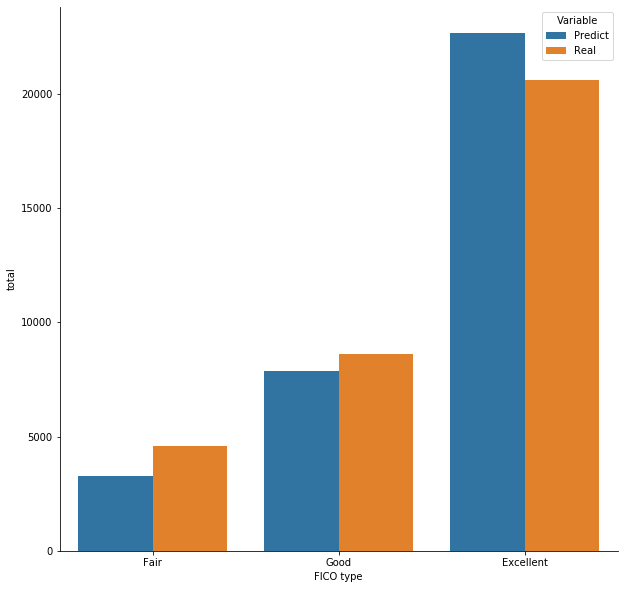

In [48]:
calculate_risk('A')